In [20]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import math
from math import sin as sin
from math import cos as cos
import time
import pandas as pd


In [21]:
import pandas as pd


file_path = 'loggut5.csv'

df_head = pd.read_csv(file_path, sep='\t', header=None, nrows=1, names=[

    'Zeit_Index',
    'Beacon0_Pos_X', 'Beacon0_Pos_Y',
    'Beacon1_Pos_X', 'Beacon1_Pos_Y',
    'Beacon2_Pos_X', 'Beacon2_Pos_Y',
    'GT_StartPos_X_Boat', 'GT_StartPos_Y_Boat' 
])


# Erst ab 2 Zeile lesen
df = pd.read_csv(file_path, sep='\t', header=None, skiprows=1, names=[
    'Zeit_Index',
    'X_GT', 'Y_GT',
    'Heading_GT', 'Heading', 'Heading_STD',
    'angle_GT_B0', 'angleDistorted_B0', 'STD_angle_B0',
    'angle_GT_B1', 'angleDistorted_B1', 'STD_angle_B1',
    'angle_GT_B2', 'angleDistorted_B2', 'STD_angle_B2',
    'Richtung_GT_X_B0', 'Richtung_GT_Y_B0',
    'Richtung_X_B0', 'Richtung_Y_B0', 'STD_Richtung_B0',
    'Richtung_GT_X_B1', 'Richtung_GT_Y_B1',
    'Richtung_X_B1', 'Richtung_Y_B1', 'STD_Richtung_B1',
    'Richtung_GT_X_B2', 'Richtung_GT_Y_B2',
    'Richtung_X_B2', 'Richtung_Y_B2', 'STD_Richtung_B2',
    'Entfernung_B0', 'EntfernungDistorted_B0', 'STD_Entfernung_B0',
    'Entfernung_B1', 'EntfernungDistorted_B1', 'STD_Entfernung_B1',
    'Entfernung_B2', 'EntfernungDistorted_B2', 'STD_Entfernung_B2'
])


#df_head

#print(df.head())
#df

In [22]:

"""
UKF mit Richtungsvektoren.
"""

# --- ---- --- --- ---- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- 

# Konfigurationsvariablen

BEACON_POSITIONS = [
                    np.array([df_head['Beacon0_Pos_X'].values[0], df_head['Beacon0_Pos_Y'].values[0]]), 
                    np.array([df_head['Beacon1_Pos_X'].values[0], df_head['Beacon1_Pos_Y'].values[0]]), 
                    np.array([df_head['Beacon2_Pos_X'].values[0], df_head['Beacon2_Pos_Y'].values[0]])
                   ]

dT = 0.1 # 10 hz => 100ms


SIGMA_ALPHA_VALUE = 0.1
SIGMA_BETA_VALUE = 2.0
SIGMA_KAPPA_VALUE = 1.0

Q_VARIANCE_VALUE = 2.0

# --- ---- --- --- ---- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- 

    

In [23]:
def f_x(state, dt):
    """
    Zustandsübergangsfunktion.
    Da die Geschwindigkeit konstant ist und der Zustand nur die Position beinhaltet,
    hat diese Funktion einfach die Geschwindigkeit zur Position hinzugefügt.
    """  
    
    x, y, vx, vy, ax, ay = state

    # Update position with current velocity and acceleration
    new_x = x + vx * dt + (ax * dt ** 2) / 2.0
    new_y = y + vy * dt + (ay * dt ** 2) / 2.0

    # Update velocity with current acceleration
    new_vx = vx + ax * dt
    new_vy = vy + ay * dt

    # Speed stays constant (no acceleration yet)
    new_ax = ax
    new_ay = ay

    return np.array([new_x, new_y, new_vx, new_vy, new_ax, new_ay])

In [24]:
def h_x(state):

    x, y, vx, vy, _, _ = state

 
    def normalize_vector(v):
        """
        Wichtig: Nulldivision-Behandlung mit implementiert! Ansonsten meckert die Vorhersage.
        Normalisiert einen Vektor. Gibt Standardvektor zurück, wenn der Eingabevektor ein Nullvektor ist.
        """
        x, y = v
        mag = np.sqrt(x ** 2 + y ** 2)
        if mag < 1e-6:  # Vermeidung Division durch Null
            return np.array([0, 1])  # Oder einen anderen Standardwert
        return np.array([x / mag, y / mag])

  
    
    def times(mat, vec):
        return np.array([
            vec[0] * mat[0] + vec[1] * mat[1],
            vec[0] * mat[2] + vec[1] * mat[3]            
            ])


    # assign beacon posis
    beacon0_pos = BEACON_POSITIONS[0]
    beacon1_pos = BEACON_POSITIONS[1]
    beacon2_pos = BEACON_POSITIONS[2]

    # calculate vectors in worldspace
    hdg = normalize_vector([vx, vy])
    b0 = normalize_vector([beacon0_pos[0] - x, beacon0_pos[1] - y])
    b1 = normalize_vector([beacon1_pos[0] - x, beacon1_pos[1] - y])
    b2 = normalize_vector([beacon2_pos[0] - x, beacon2_pos[1] - y])

    # ships rotation-mat and its inverser
    ship_mat_ws = np.array([
        hdg[1], +hdg[0],
        -hdg[0], hdg[1]
    ])
    
    ship_mat_ws_inv = np.array([
        hdg[1], -hdg[0],
        +hdg[0], hdg[1]
    ])

    # convert b0, b1 and b2 from worldspace to ships modelspace
    b0 = times(ship_mat_ws_inv, b0)
    b1 = times(ship_mat_ws_inv, b1)
    b2 = times(ship_mat_ws_inv, b2)
    
    # hdg[0], hdg[1], 
    return np.array([b0[0], b0[1], b1[0], b1[1], b2[0], b2[1]])

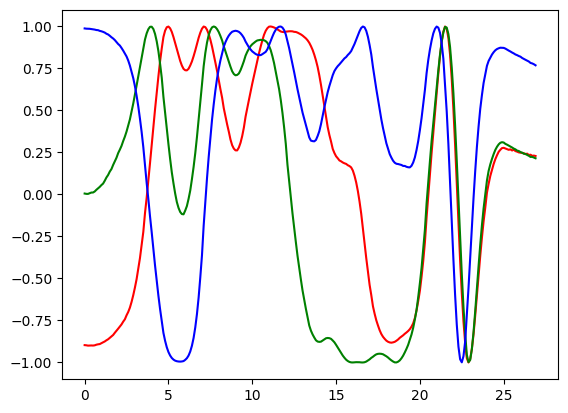

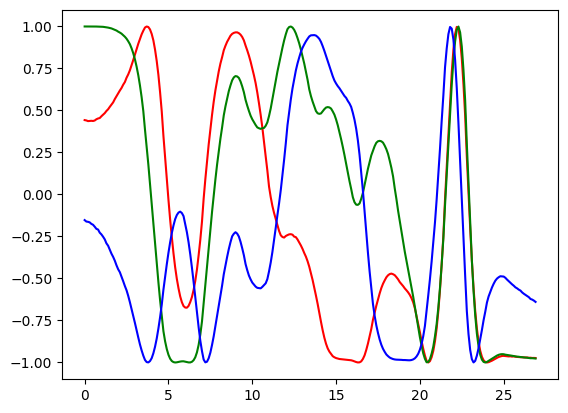

In [25]:
z0 = []
z1 = []
z2 = []

for index, row in df.iterrows():
    z0.append([row['Richtung_X_B0'], row['Richtung_Y_B0']])
    z1.append([row['Richtung_X_B1'], row['Richtung_Y_B1']])
    z2.append([row['Richtung_X_B2'], row['Richtung_Y_B2']])

t = [(i * dT) for i in range(len(df))]

z0x = [h[0] for h in z0]
z0y = [h[1] for h in z0]

z1x = [h[0] for h in z1]
z1y = [h[1] for h in z1]

z2x = [h[0] for h in z2]
z2y = [h[1] for h in z2]

plt.plot(t, z0x, label='Geschätzer Weg', linestyle='-', color='red', markersize=4)
plt.plot(t, z1x, label='Geschätzer Weg', linestyle='-', color='green', markersize=4)
plt.plot(t, z2x, label='Geschätzer Weg', linestyle='-', color='blue', markersize=4)
plt.show()


plt.plot(t, z0y, label='Geschätzer Weg', color='red', markersize=4)
plt.plot(t, z1y, label='Geschätzer Weg', linestyle='-', color='green', markersize=4)
plt.plot(t, z2y, label='Geschätzer Weg', linestyle='-', color='blue', markersize=4)
plt.show()

In [26]:

# UKF

sigmas = MerweScaledSigmaPoints(n=6, alpha=SIGMA_ALPHA_VALUE, beta=SIGMA_BETA_VALUE, kappa=SIGMA_KAPPA_VALUE)

ukf = UKF(dim_x=6, dim_z=6, fx=f_x, hx=h_x, dt=dT, points=sigmas)
#ukf.x = states[0].copy() # ggf. kontrollieren

# Initialzustand aus dem ersten Logeintrag holen
init_state = np.array([
    df['X_GT'].values[0], df['Y_GT'].values[0],  # x, y
    0, 0,  # vx, vy
    0, 0   # ax, ay
])

ukf.x = init_state


ukf.Q = Q_discrete_white_noise(dim=2, dt=dT, var=Q_VARIANCE_VALUE, block_size=3, order_by_dim=False)

# Speichere geschätzten Zustände und Kovarianzmatrizen
uxs = []
uPs = []

# Iteriere durch jede Zeile im Df
for index, row in df.iterrows():

    # Hole die Standardabweichungen für die aktuelle Messung, verkleine diese, um sie von Grad zu norm. Vektoren anzupassen, das ist nur eine math. Näherung!
    std_b0 = row['STD_Richtung_B0'] / 1000
    std_b1 = row['STD_Richtung_B1'] / 1000
    std_b2 = row['STD_Richtung_B2'] / 1000

    # Zeige Std zwecks Korrektheit
    #print(std_b0, std_b1, std_b2)
    
    # Setze die Rauschmatrix R basierend auf den extrahierten Standardabweichungen immer neu
    ukf.R = np.diag([std_b0 ** 2, std_b0 ** 2, std_b1 ** 2, std_b1 ** 2, std_b2 ** 2, std_b2 ** 2])

    # Prüfe ob Std. in R-Matrix gesetzt werden
    # print(ukf.R)
    
    # Hole den aktuellen Messvektor z
    z = np.array([
        row['Richtung_X_B0'], row['Richtung_Y_B0'],
        row['Richtung_X_B1'], row['Richtung_Y_B1'],
        row['Richtung_X_B2'], row['Richtung_Y_B2']
    ])

    # Check ob Daten korrekt eingelesen sind
    # print(z)
    
    # Vorhersage und Update mit dem aktuellen Messvektor
    ukf.predict()
    ukf.update(z)
    
    # Speichere die geschätzten Zustände und Kovarianzmatrizen
    uxs.append(ukf.x.copy())
    uPs.append(ukf.P.copy())

uxs = np.array(uxs)


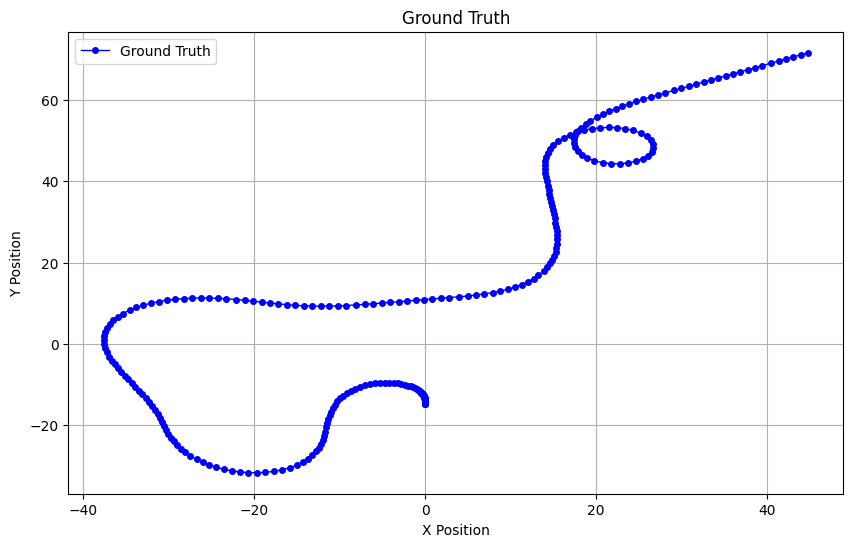

In [27]:
plt.figure(figsize=(10, 6))

plt.plot(df['X_GT'], df['Y_GT'], marker='o', linestyle='-', color='blue', markersize=4, linewidth=1, label='Ground Truth')

plt.title('Ground Truth')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)

plt.show()

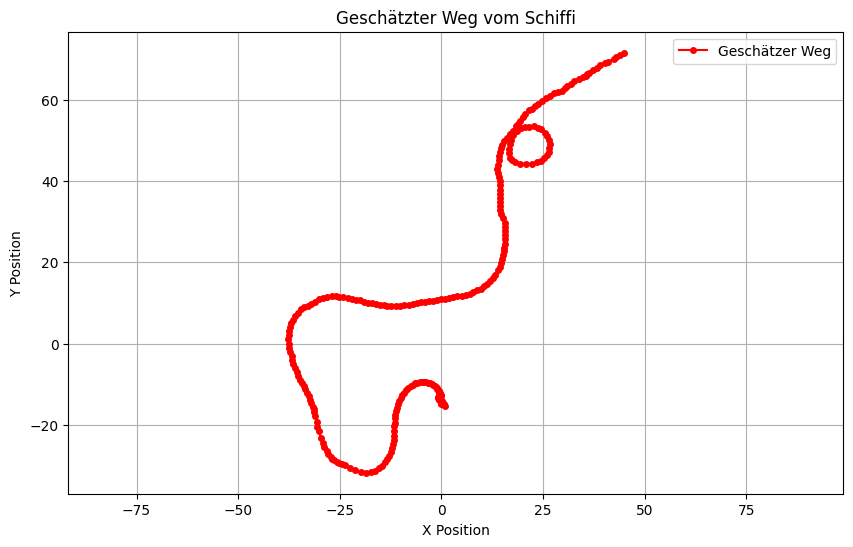

In [28]:

"""
Plot
"""
plt.figure(figsize=(10, 6))
ux_val = [s[0] for s in uxs]
uy_val = [s[1] for s in uxs]
plt.plot(ux_val, uy_val, label='Geschätzer Weg', marker='o', linestyle='-', color='red', markersize=4)

plt.title('Geschätzter Weg vom Schiffi')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Stellt sicher, dass die Skalierung auf beiden Achsen gleich ist
plt.show()

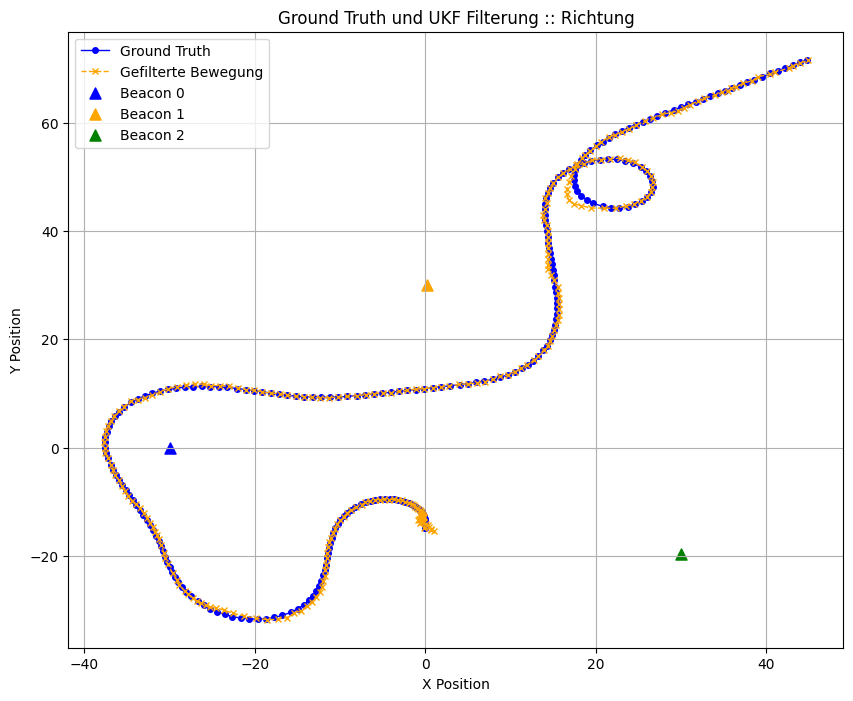

In [32]:
# Wichtig: Scatter statt Plot verwenden falls keine Verbindungslinien gezeichnet werden sollen!

def plotte_gt_and_estimate(gt_x, gt_y, x_esti, y_esti, beacons, title='Ground Truth und UKF Filterung - Richtungsvektoren'):
    
    plt.figure(figsize=(10, 8))
    
    # Plot Ground Truth und geschätzte Position
    plt.plot(gt_x, gt_y, 'b-', label='Ground Truth', marker='o', markersize=4, linewidth=1)
    plt.plot(x_esti, y_esti, label='Gefilterte Bewegung', marker='x', markersize=4, linewidth=1, linestyle='--', color='orange')
    
    # Farben für die Beacons
    beacon_colors = ['blue', 'orange', 'green']
    
    # Beacons
    for i, beacon in enumerate(beacons):
        plt.scatter(beacon[0], beacon[1], s=64, color=beacon_colors[i], label=f'Beacon {i}', marker='^')

    
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    
    plt.legend()
    
    plt.grid(True)
    plt.show()


# BEACON_POSITIONS muss als Liste von [x, y] Koordinaten definiert sein
beacons_xy = [[beacon[0], beacon[1]] for beacon in BEACON_POSITIONS]


ux_val = [s[0] for s in uxs]
uy_val = [s[1] for s in uxs]


gt_x = df['X_GT'].tolist()
gt_y = df['Y_GT'].tolist()

plotte_gt_and_estimate(gt_x, gt_y, ux_val, uy_val, beacons_xy)


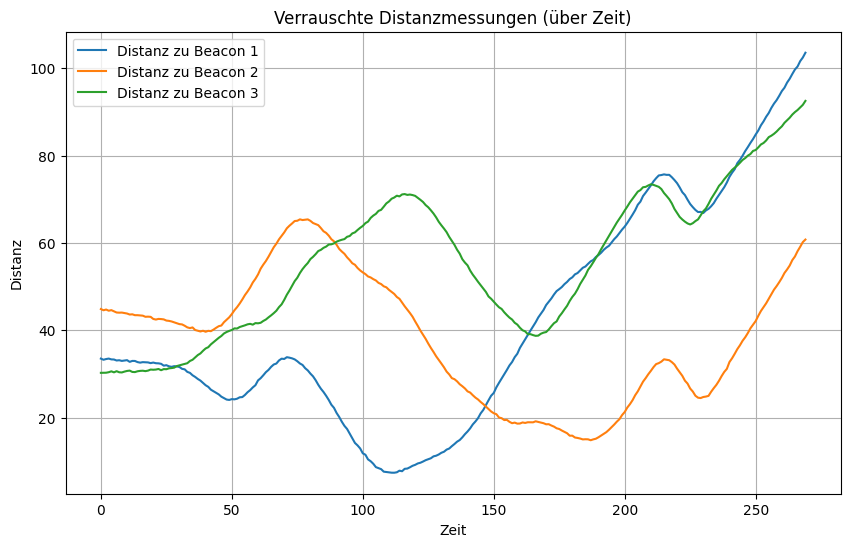

In [30]:

def plotte_noisy_distances(time_steps, noisy_distances):
    
    plt.figure(figsize=(10, 6))
    
    for i in range(noisy_distances.shape[1]):
        plt.plot(time_steps, noisy_distances[:, i], label=f'Distanz zu Beacon {i+1}')
    
    plt.title('Verrauschte Richtungsvektorenmessungen (über Zeit) - Richtungsvektoren')
    plt.xlabel('Zeit')
    plt.ylabel('Distanz')
    
    plt.legend()
    
    plt.grid(True)
    plt.show()



# df enthältverrauschten Distanzmessungen zu den Beacons in separaten Spalten
# dh.Zeit relativ zum Index der Datei
time_steps = df.index
noisy_distances = df[['EntfernungDistorted_B0', 'EntfernungDistorted_B1', 'EntfernungDistorted_B2']].values

plotte_noisy_distances(time_steps, noisy_distances)

In [ ]:
## Auswertungsfunktionen ##
## ==> RMSE für Strecke  
def calc_rmse(uxs, gt):
    """
    Berechne den Root-Square-Mean-Error zwischen den UKF-Schätzungen und dem GT.
    """

    if len(uxs) == 0:
        raise ValueError("Liste der Schätzung ist leer!")
    
    if len(uxs) != len(gt):
        raise ValueError("Schätzungen sind nicht gleich so lang wie GT.")

    # Position, erste beiden Spalten
    uxs_posi = uxs[:, :2]

    rmse = np.sqrt(((uxs_posi - gt) ** 2).mean(axis=0))

    return rmse


gt= df[['X_GT', 'Y_GT']].values

rmse = calc_rmse(uxs, gt)

print("RMSE (für x und y) ist:", rmse)

In [ ]:

def calc_delta(uxs, gt):
    """
    Berechne Delta von geschätzten und GT (wahren Werten)
    """

    if len(uxs) == 0:
        raise ValueError("Liste der Schätzung ist leer!")
    
    if len(uxs) != len(gt):
        raise ValueError("Schätzungen sind nicht gleich so lang wie GT.")


    uxs_p = uxs[:, :2] # Positionen
    uxs_v = uxs[:, 2:4] # Geschwindigkeiten
    uxs_a = uxs[:, 4:6] # Beschleunigungen

    #
    #t = [(2 * i * dT) for i in range(len(uxs_p))]
    #plt.plot(t, delta_p, color = 'green')

    delta_x = (uxs[:, 0:1] - gt[:, 0:1]) 
    delta_y = (uxs[:, 1:2] - gt[:, 1:2])


    delta_p = np.sqrt((delta_x ** 2) + (delta_y ** 2))

    t = [(2 * i * dT) for i in range(len(delta_x))]

    #plt.plot(t, delta_x, color = 'green')
    #plt.plot(t, delta_y, color = 'blue')
    #plt.show()

    # Delta: zwischen geschätzten und Ground Truth (GT) Positionen
    plt.plot(t, delta_p, color = 'orange', label='Delta der Position (x,y)')

    # --- POSI.

    varianz_px = np.array([P[0,0] for P in uPs])
    varianz_py = np.array([P[1,1] for P in uPs])

    varianz_p = np.sqrt(varianz_px + varianz_py)

    plt.plot(t, varianz_p, color = 'red', label='Position Varianz')

    # --- VELO.

    varianz_vx = np.array([P[2,2] for P in uPs])
    varianz_vy = np.array([P[3,3] for P in uPs])

    varianz_v = np.sqrt(varianz_vx + varianz_vy)

    plt.plot(t, varianz_v, color = 'green', label='Geschwindigkeit Varianz')

    # --- ACC.

    varianz_ax = np.array([P[4,4] for P in uPs])
    varianz_ay = np.array([P[5,5] for P in uPs])

    varianz_a = np.sqrt(varianz_ax + varianz_ay)

    plt.plot(t, varianz_a, color = 'blue', label='Beschleunigung Varianz')


    plt.legend()

    #plt.xlim(-1, 61)
    #plt.ylim(0, 10)



gt= df[['X_GT', 'Y_GT']].values
calc_delta(uxs, gt)


